In [1]:
import os  
import numpy as np  
import torch  
import matplotlib.pyplot as plt  
from tqdm import tqdm  
import shutil
from ultralytics import YOLO 
import cv2
import random
import splitfolders

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
model = YOLO('models/full.pt')
# model = torch.hub.load('ultralytics/yolov5', 'custom', path='models/best.pt')
print(model.info())

Model summary: 225 layers, 3,012,213 parameters, 0 gradients, 8.2 GFLOPs
(225, 3012213, 0, 8.2006016)


In [25]:
# img = 'random_frame.jpg' 
video_path = r"recordings\2024-08-30\recording_20240830_1131.avi"
# results = model.predict(img)
# result_array = results[0].plot()
# plt.imshow(result_array)
# plt.show()

In [26]:
shutil.rmtree('runs')

In [27]:
results = model.predict(video_path, save_txt=True, save_conf=False, verbose=False) # stream=True, save=False


WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to runs\detect\predict
755 labels saved to runs\detect\predict\labels


In [32]:
labels_path = 'runs\\detect\\predict\\labels'
save_path_base = 'recordings\\2024-08-30'

labels = [os.path.join(labels_path, file) for file in os.listdir(labels_path)]

if labels:
    first_file = labels[0]
    base_name = os.path.splitext(os.path.basename(first_file))[0]
    parts = base_name.split('_')
    # 'recording_20240829_1200_1.txt
    # ['recording', '20240829', '1200', '1']
    timestamp = '_'.join(parts[-3:-1])

new_directory = os.path.join(save_path_base, timestamp, 'obj_train_data')
if not os.path.exists(new_directory):
    os.makedirs(new_directory)

for label in tqdm(labels, desc="Copying files", unit="file"):
    directory, file_name = os.path.split(label)

    base_name, ext = os.path.splitext(file_name)  
    parts = base_name.split('_') 
    number = int(parts[-1])
    number-=1 # start from 0

    new_number = f"{number:06d}"

    new_file_name = f"frame_{new_number}{ext}"
    new_file_path = os.path.join(new_directory, new_file_name)

    shutil.copy(label, new_file_path)

print("Files are copied.")

Copying files: 100%|██████████| 755/755 [00:03<00:00, 222.37file/s]

Files are copied.


In [33]:
train_txt = os.path.join(os.path.dirname(new_directory), 'train.txt')

txt_files = [file for file in os.listdir(new_directory) if file.endswith('.txt')]

with open(train_txt, 'w') as f:
    for file in txt_files:
        base_name, _ = os.path.splitext(file)
        new_file_name = f"data/obj_train_data/{base_name}.PNG"
        f.write(new_file_name + '\n')

print("train.txt is created.")

train.txt is created.


In [34]:
obj_data = "Template_YOLO_DataFormat\\obj.data"
obj_names = "Template_YOLO_DataFormat\\obj.names"

shutil.copy(obj_data, os.path.dirname(new_directory))
shutil.copy(obj_names, os.path.dirname(new_directory))

'recordings\\2024-08-30\\20240830_1131\\obj.names'

In [35]:
folder_to_zip = os.path.dirname(new_directory)
output_zip_path = f"{folder_to_zip}_zipped"

# Create the zip file
shutil.make_archive(output_zip_path, 'zip', folder_to_zip)
print("Zipped successfully.")

Zipped successfully.


In [4]:
base_folder = 'Train_Dataset'

src_folders = [os.path.join(base_folder, path, 'obj_train_data') for path in os.listdir(base_folder) if not path.endswith('.zip')]
src_folders

['Train_Dataset\\Task_1\\obj_train_data',
 'Train_Dataset\\Task_2\\obj_train_data',
 'Train_Dataset\\Task_3\\obj_train_data',
 'Train_Dataset\\Task_4\\obj_train_data',
 'Train_Dataset\\Task_5\\obj_train_data',
 'Train_Dataset\\Task_6\\obj_train_data',
 'Train_Dataset\\Task_7\\obj_train_data']

In [5]:
images_dest = 'Train_Dataset/datasets/images/'
labels_dest = 'Train_Dataset/datasets/labels/'

os.makedirs(images_dest, exist_ok=True)
os.makedirs(labels_dest, exist_ok=True)

image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

count = 0

for folder in src_folders:
    print(f"Processing folder: {folder}")
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if os.path.isfile(file_path):
            base_name, ext = os.path.splitext(filename)
            ext = ext.lower()

            # Check if the file is an image
            if ext in image_extensions:
                # New filename for the image
                new_filename = f'image_{count:06d}.jpg'
                new_image_path = os.path.join(images_dest, new_filename)

                # Copy the image to the directory
                shutil.copyfile(file_path, new_image_path)

                # Check for corresponding label file
                label_filename = base_name + '.txt'
                label_file_path = os.path.join(folder, label_filename)
                if os.path.isfile(label_file_path):
                    # New filename for the label
                    new_label_filename = f'image_{count:06d}.txt'
                    new_label_path = os.path.join(labels_dest, new_label_filename)

                    # Copy the label with the new name
                    shutil.copyfile(label_file_path, new_label_path)
                else:
                    print(f"Warning: No label file found for image {file_path}")

                count += 1

            elif ext == '.txt':
                # If the file is a label file but its corresponding image was already processed, skip it
                continue
            else:
                print(f"Warning: Unrecognized file format {file_path}")
else:
    print("Processing complete.")
    print(f"Total images processed: {count}")


Processing folder: Train_Dataset\Task_1\obj_train_data
Processing folder: Train_Dataset\Task_2\obj_train_data
Processing folder: Train_Dataset\Task_3\obj_train_data
Processing folder: Train_Dataset\Task_4\obj_train_data
Processing folder: Train_Dataset\Task_5\obj_train_data
Processing folder: Train_Dataset\Task_6\obj_train_data
Processing folder: Train_Dataset\Task_7\obj_train_data
Processing complete.
Total images processed: 565


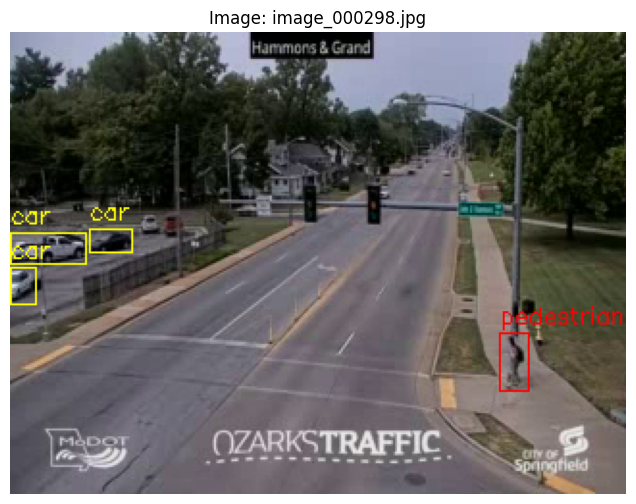

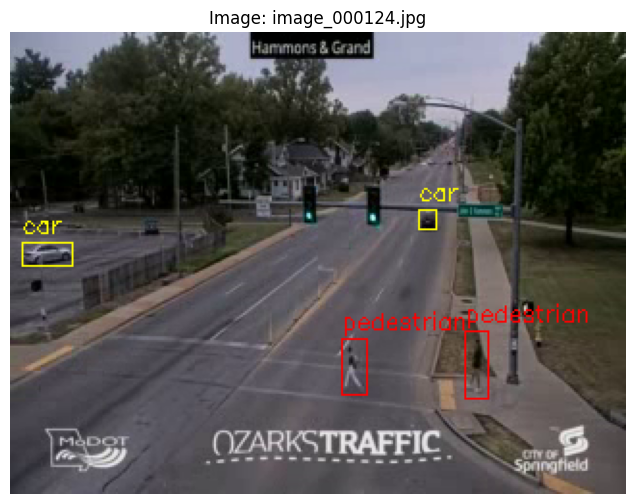

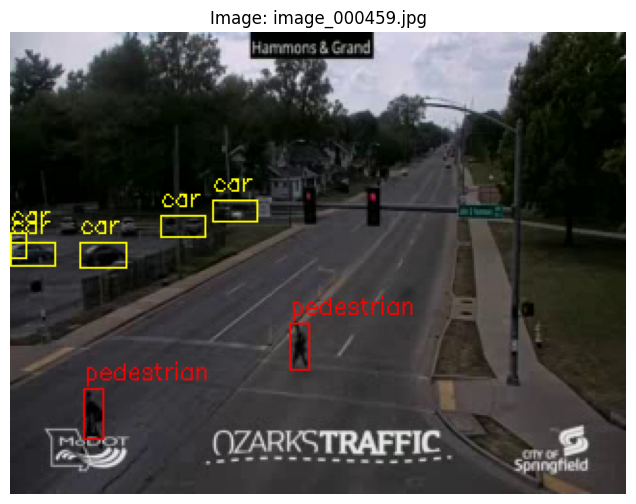

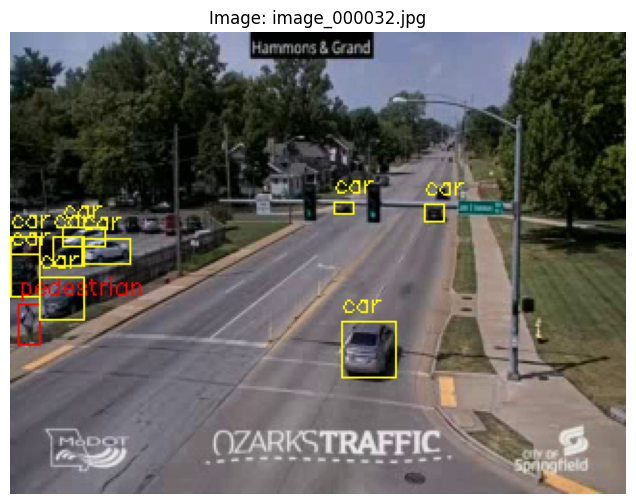

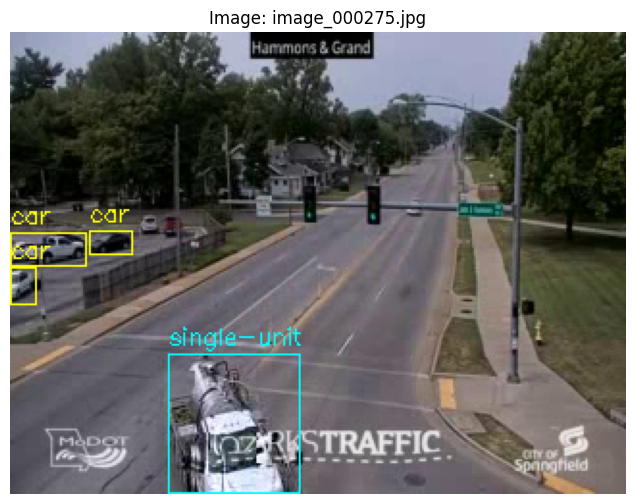

In [6]:
num_samples = 5

image_files = [f for f in os.listdir(images_dest) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.PNG'))]
random_images = random.sample(image_files, num_samples)

"""
 0: 'pedestrian',
 1: 'cyclist',
 2: 'motorcycle',
 3: 'car',
 4: 'bus',
 5: 'single-unit',
 6: 'trucks'
 """

colors = [
    (255, 0, 0),    
    (0, 255, 0),    
    (0, 0, 255),   
    (255, 255, 0),  
    (255, 0, 255),  
    (0, 255, 255),  
    (128, 128, 128) 
]

class_names = ['pedestrian', 'cyclist', 'motorcycle', 'car', 'bus', 'single-unit', 'trucks']

for image_file in random_images:
    image_path = os.path.join(images_dest, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

    base_name = os.path.splitext(image_file)[0]
    label_file = base_name + '.txt'
    label_path = os.path.join(labels_dest, label_file)

    if os.path.isfile(label_path):
        with open(label_path, 'r') as f:
            labels = f.readlines()

        height, width, _ = image.shape

        # Plot bounding boxes
        for label in labels:
            label = label.strip()
            if label == '':
                continue
            class_id, x_center, y_center, w, h = map(float, label.split())
            class_id = int(class_id)

            x_center *= width
            y_center *= height
            w *= width
            h *= height

            x_min = int(x_center - w / 2)
            y_min = int(y_center - h / 2)
            x_max = int(x_center + w / 2)
            y_max = int(y_center + h / 2)


            color = colors[class_id % len(colors)]

            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness=1)

            label_text = class_names[class_id] if class_id < len(class_names) else str(class_id)

            cv2.putText(
                image,
                label_text,
                (x_min, y_min - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.4,
                color=color,
                thickness=1
            )

    else:
        print(f"Label file not found for image {image_file}")

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image: {image_file}")
    plt.show()

In [8]:
input_folder = "Dataset/Combined"
output_folder = "Dataset/yolo_dataset"
os.makedirs(output_folder, exist_ok=True)

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.80, .20), group_prefix=None)

Copying files: 40006 files [06:11, 107.59 files/s]
